In [1]:
!pip install -U spaCy
!pip install keras
!python -m spacy download it_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Text Categorization

The goal is to classify documents according to a set of predefined classes (labels).

We need training data for training a supervised approaches.

The process for training a classifier:
1. Load training data
2. Data pre-processing
3. Create and extract features
4. Training a model

For testing:
1. Load test data
2. Generate feature using the same approach adopted during the training
3. Classify test instances
4. Compute metrics

We use spaCy for text processing and scikit-learn for machine learning.

We define some functions for text processing.
We build also a class for implementing a custom Trasformer based on spaCy. This trasformer will process the text.

In [2]:
import string
import spacy
import json
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn import neural_network
from sklearn import ensemble

#init spaCy
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = spacy.lang.it.stop_words.STOP_WORDS
parser = Italian()

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

Training data loading and features extraction.
We exploit BoW with the TfIdf as features.

Data available here: https://drive.google.com/drive/folders/1pQKHrUth2x3lR-W74LKwtke-kQRIbR6U?usp=drive_link

In [3]:
df = open('dataset_05.json','r')
X = []
y = []

for line in df:
  j = json.loads(line)
  # the features: title, desc, text
  #X.append(j['title'])
  X.append(j['title']+' '+j['desc'])
  #X.append(j['title']+' '+j['desc']+' '+(j['text'] if 'text' in j  else ''))
  y.append(j['topic']) # the labels

#BoW with word count
#vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
#BoW with TF-IDF
vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

print(X[0])
print(y[0])

Politica. Miccoli (Pd): Una coalizione sociale per Cosenza e battere la destra - Reggio TV Politica. Miccoli (Pd): Una coalizione sociale per Cosenza e battere la destra  Reggio TV
politica


Split in train and test data.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Build the model.

In [5]:
# Linear Support Vector Machine classifier
classifier = svm.LinearSVC(max_iter=1000)
# Multi-layer Perceptron classifier
#classifier = neural_network.MLPClassifier(hidden_layer_sizes=(512,),verbose=True,max_iter=40)
# Random Foreset
#classifier = ensemble.RandomForestClassifier()
# Create the pipeline
pipe = Pipeline([("cleaner", predictors()),
('vectorizer', vector),
('classifier', classifier)])
# Fit the model
pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7cfc5a6cde50>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7cfc5f598a40>)),
                ('classifier', LinearSVC())])

Compute predictions on the test set and calculate metrics.

In [6]:
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print("======================================================")
precision_macro = metrics.precision_score(y_test, predicted, average='macro')
recall_macro = metrics.recall_score(y_test, predicted, average='macro')
fm_macro = metrics.f1_score(y_test, predicted, average='macro')
print("P-macro={0}, R-macro={1}, F1-macro={2}".format(precision_macro, recall_macro, fm_macro))
print("======================================================")
precision_micro = metrics.precision_score(y_test, predicted, average='micro')
recall_micro = metrics.recall_score(y_test, predicted, average='micro')
fm_micro = metrics.f1_score(y_test, predicted, average='micro')
print("P-micro={0}, R-micro={1}, F1-micro={2}".format(precision_micro, recall_micro, fm_micro))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Accuracy: 0.8019201616978272
P-macro=0.7793342188783638, R-macro=0.7411659898257534, F1-macro=0.7556045271964779
P-micro=0.8019201616978272, R-micro=0.8019201616978272, F1-micro=0.8019201616978272
                  precision    recall  f1-score   support

        ambiente     0.7470    0.6667    0.7045        93
animali e natura     0.5357    0.4455    0.4865       101
     cinema e tv     0.7736    0.7736    0.7736        53
         cronaca     0.7182    0.8952    0.7970       353
         cultura     0.9357    0.9091    0.9222       176
        economia     0.8556    0.8556    0.8556       180
          estero     0.6444    0.6905    0.6667        84
          motori     0.8989    0.8081    0.8511        99
        politica     0.8869    0.8765    0.8817       170
          salute     0.6349    0.5797    0.6061        69
         scienza     0.6897    0.3922    0.5000        51
      spettecolo     0.7589    0.7870    0.7727       108
           sport     0.8944    0.8571    0.8754 

Build the confusion matrix.

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
print(cm)

[[ 62   9   0   7   1   3   1   1   1   2   1   5   0   0]
 [  7  45   0  14   1   1   3   0   0  21   3   4   0   2]
 [  0   2  41   3   1   0   0   1   1   0   0   2   2   0]
 [  0   7   1 316   1   7   4   0   5   0   0   3   8   1]
 [  0   2   1   6 160   0   1   0   0   0   0   4   2   0]
 [  3   0   0  12   2 154   3   1   2   0   0   2   1   0]
 [  2   2   3   7   0   3  58   2   5   0   0   1   0   1]
 [  0   0   0   2   0   0   2  80   0   0   0   0  14   1]
 [  1   0   0  11   0   5   1   0 149   0   0   0   3   0]
 [  2   8   1   5   0   0   3   1   2  40   2   3   2   0]
 [  5   3   0   5   2   2   6   0   2   0  20   3   2   1]
 [  0   4   5   6   3   1   4   0   0   0   0  85   0   0]
 [  0   0   0  44   0   0   2   1   1   0   0   0 288   0]
 [  1   2   1   2   0   4   2   2   0   0   3   0   0  89]]


Visualize the confusion matrix.

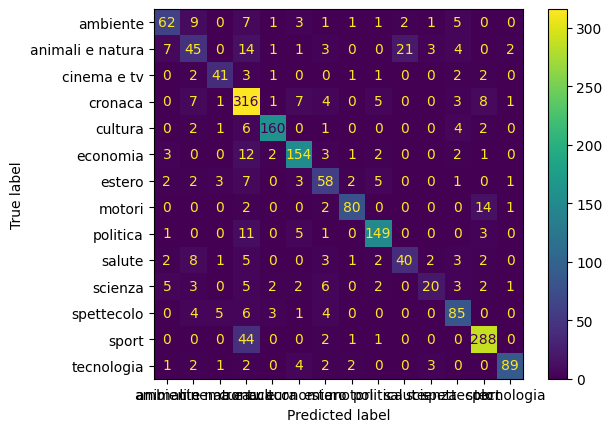

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Using embeddings for the classification

Each training document is represented as a vector obtained by averaging word embeddings.
We use embeddings provided by the spaCy Italian model.

In [9]:
df = open('dataset_05.json','r')
X = []
y = []
for line in df:
  j = json.loads(line)
  #text = j['title']
  text = j['title']+' '+j['desc']
  #text = j['title']+' '+j['desc']+' '+(j['text'] if 'text' in j  else '')
  doc = nlp(text)
  X.append(doc.vector) # the document embedding
  y.append(j['topic']) # the labels

print(X[0])
print(y[0])

[-1.0833882e-01  1.0392547e+00  1.0564259e+00  1.6304943e-01
  2.9617369e-01  9.1402584e-01  2.9813290e-01 -6.6320729e-01
  3.3584554e-02  1.5647183e-01  2.8467691e-01 -4.2411312e-01
 -7.8567022e-01  6.8779874e-01  1.6984793e+00  3.8405454e-01
  9.2832512e-01  6.5822941e-01 -3.1387943e-01  8.5837656e-01
  2.4339724e-01  2.1476223e-01 -1.0063527e+00  3.0016363e-01
 -1.3023633e-01  8.6663151e-01  1.3915501e+00  2.4116223e-01
  1.5893376e+00  5.1701564e-01 -4.1217053e-01  1.6807765e-02
 -3.3118007e-01 -1.7921075e-01  7.6756608e-01  6.3664383e-01
 -8.0296260e-01  1.3835478e+00  7.3183703e-01 -3.2136774e-01
  1.2513324e+00 -9.3886387e-01  6.3286889e-01 -1.4156127e+00
 -4.8152664e-01  9.6395439e-01 -6.7634255e-01 -3.5379818e-01
  8.9094394e-01 -3.5028765e-01  2.0085457e-01 -4.4883516e-01
 -1.0708172e+00 -2.8189306e+00  3.3119583e-01  1.7333776e-01
  9.2621273e-01 -2.4959006e+00 -8.4203047e-01  1.2342910e-02
 -2.2346719e-01  4.4863075e-01 -1.2576834e+00 -5.3146172e-01
 -2.8829825e-01 -4.40818

Execute train and test by using embeddings.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = svm.LinearSVC(max_iter=1000)
#classifier = neural_network.MLPClassifier(hidden_layer_sizes=(1024,),verbose=True,max_iter=25)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print("======================================================")
precision_macro = metrics.precision_score(y_test, predicted, average='macro')
recall_macro = metrics.recall_score(y_test, predicted, average='macro')
fm_macro = metrics.f1_score(y_test, predicted, average='macro')
print("P-macro={0}, R-macro={1}, F1-macro={2}".format(precision_macro, recall_macro, fm_macro))
print("======================================================")
precision_micro = metrics.precision_score(y_test, predicted, average='micro')
recall_micro = metrics.recall_score(y_test, predicted, average='micro')
fm_micro = metrics.f1_score(y_test, predicted, average='micro')
print("P-micro={0}, R-micro={1}, F1-micro={2}".format(precision_micro, recall_micro, fm_micro))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Accuracy: 0.7518948964123294
P-macro=0.6998151628428589, R-macro=0.6765472773653691, F1-macro=0.6852185577199567
P-micro=0.7518948964123294, R-micro=0.7518948964123294, F1-micro=0.7518948964123294
                  precision    recall  f1-score   support

        ambiente     0.6629    0.6344    0.6484        93
animali e natura     0.5253    0.5149    0.5200       101
     cinema e tv     0.5667    0.6415    0.6018        53
         cronaca     0.7532    0.8385    0.7936       353
         cultura     0.7926    0.8466    0.8187       176
        economia     0.8212    0.8167    0.8189       180
          estero     0.5122    0.5000    0.5060        84
          motori     0.8283    0.8283    0.8283        99
        politica     0.7529    0.7529    0.7529       170
          salute     0.6154    0.4638    0.5289        69
         scienza     0.4857    0.3333    0.3953        51
      spettecolo     0.7429    0.7222    0.7324       108
           sport     0.8692    0.8899    0.8794 

# Excerice

Try to improve classification performance on Haspeede and HODI datasets using word embeddings.